In [1]:
import numpy as np
import pandas as pd
import math
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedStratifiedKFold, GridSearchCV
from sklearn import metrics
from sklearn.preprocessing import OneHotEncoder, StandardScaler, normalize, RobustScaler, MinMaxScaler, LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

seed = 33

### Reading data

In [2]:
df = pd.read_csv('dataset/winequality-white.csv', sep=';')
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


### Studying data

In [3]:
# Check null values
df.isnull().any()

fixed acidity           False
volatile acidity        False
citric acid             False
residual sugar          False
chlorides               False
free sulfur dioxide     False
total sulfur dioxide    False
density                 False
pH                      False
sulphates               False
alcohol                 False
quality                 False
dtype: bool

In [4]:
# View features description
df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,4899.000000,4899.000000,4899.000000,4899.000000,4899.000000,4899.000000,4899.000000,4899.000000,4899.000000,4899.000000,4899.000000,4899.000000
mean,6.854736,0.278258,0.334182,6.390437,0.045767,35.305777,138.349765,0.994026,3.188312,0.489871,10.514652,5.878547
std,0.843790,0.100791,0.121009,5.072002,0.021849,17.006169,42.500564,0.002991,0.151018,0.114127,1.230790,0.886671
min,3.800000,0.080000,0.000000,0.600000,0.009000,2.000000,9.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.300000,0.210000,0.270000,1.700000,0.036000,23.000000,108.000000,0.991720,3.090000,0.410000,9.500000,5.000000
50%,6.800000,0.260000,0.320000,5.200000,0.043000,34.000000,134.000000,0.993740,3.180000,0.470000,10.400000,6.000000
75%,7.300000,0.320000,0.390000,9.900000,0.050000,46.000000,167.000000,0.996100,3.280000,0.550000,11.400000,6.000000
max,14.200000,1.100000,1.660000,65.800000,0.346000,289.000000,440.000000,1.038980,3.820000,1.080000,14.200000,9.000000


In [5]:
df['quality'].value_counts()

6    2198
5    1457
7     880
8     175
4     163
3      20
9       6
Name: quality, dtype: int64

array([[<AxesSubplot:title={'center':'quality'}>]], dtype=object)

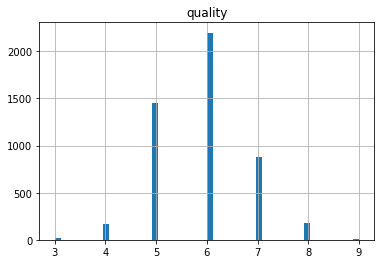

In [6]:
df.hist(column='quality', bins=50)

In [7]:
def iqr_outliers(df):
    out=[]
    q1 = df.quantile(0.25)
    q3 = df.quantile(0.75)
    iqr = q3-q1
    Lower_tail = q1 - 1.5 * iqr
    Upper_tail = q3 + 1.5 * iqr
    for i in df:
        if i > Upper_tail or i < Lower_tail:
            out.append(i)
    return out

In [8]:
count = 0
for name in list(df.iloc[:, :-1]):
    print(name)
    outliers = iqr_outliers(df[name])
    count += len(outliers)
print('Total: ', count)

fixed acidity
volatile acidity
citric acid
residual sugar
chlorides
free sulfur dioxide
total sulfur dioxide
density
pH
sulphates
alcohol
Total:  1063


<AxesSubplot:>

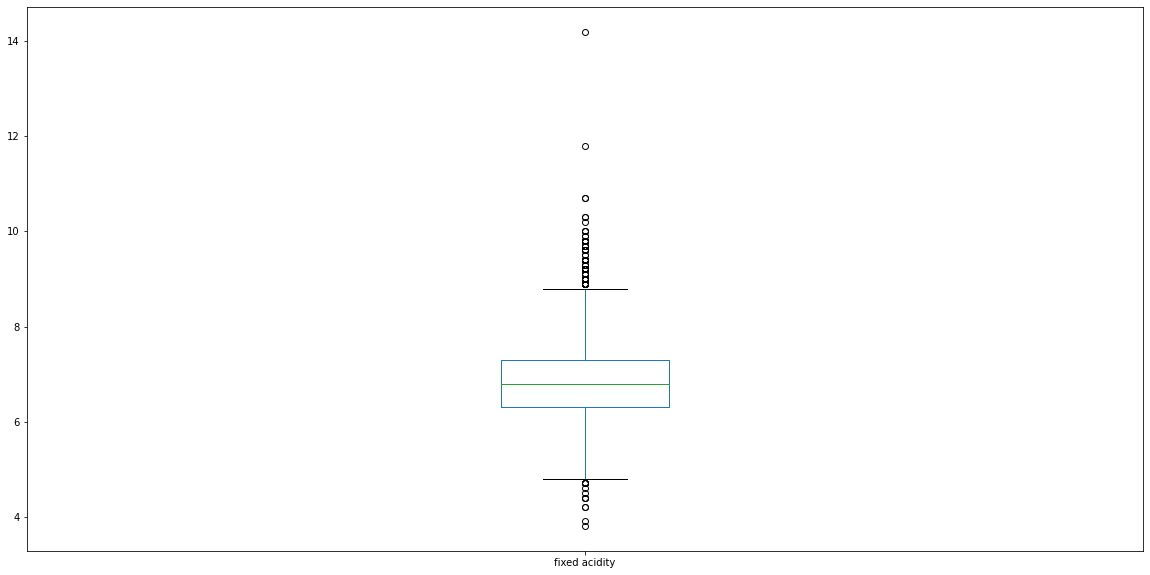

In [9]:
fig = plt.figure(figsize = (20,10))
df.boxplot(column=['fixed acidity'], grid=False)

#### Detect features and target

In [10]:
bins = (1, 4.5, 7.5, 10)
group_names = ['bad', 'good', 'high']
df['quality'] = pd.cut(df['quality'], bins = bins, labels = group_names)

In [11]:
df['quality'].value_counts()

good    4535
bad      183
high     181
Name: quality, dtype: int64

In [12]:
label_quality = LabelEncoder()
df['quality'] = label_quality.fit_transform(df['quality'])

array([[<AxesSubplot:title={'center':'quality'}>]], dtype=object)

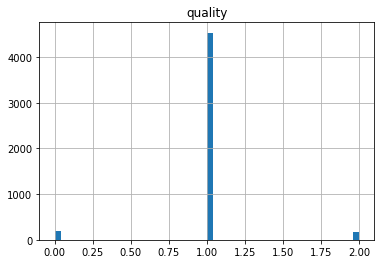

In [13]:
df.hist(column='quality', bins=50)

In [14]:
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

print(X.shape)
print(y.shape)

(4899, 11)
(4899,)


#### Preprocessing

In [15]:
scaler = RobustScaler()
X = scaler.fit_transform(X)

(11407, 11)
(11407,)


<AxesSubplot:>

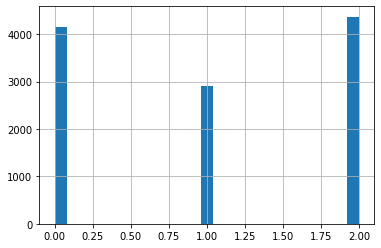

In [15]:
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

# Balance dataset
over = SMOTEENN()

X, y = over.fit_resample(X, y)
print(X.shape)
print(y.shape)
y.hist(bins=25)

In [16]:
balanced_scaled_df = pd.DataFrame(X, columns = [name for name in list(df.iloc[:, :-1])])

In [17]:
count = 0
for name in list(df.iloc[:, :-1]):
    print(name)
    outliers = iqr_outliers(balanced_scaled_df[name])
    count += len(outliers)
print('Total: ', count)

fixed acidity
volatile acidity
citric acid
residual sugar
chlorides
free sulfur dioxide
total sulfur dioxide
density
pH
sulphates
alcohol
Total:  3048


### Feature selection 

#### By correlation 

<AxesSubplot:>

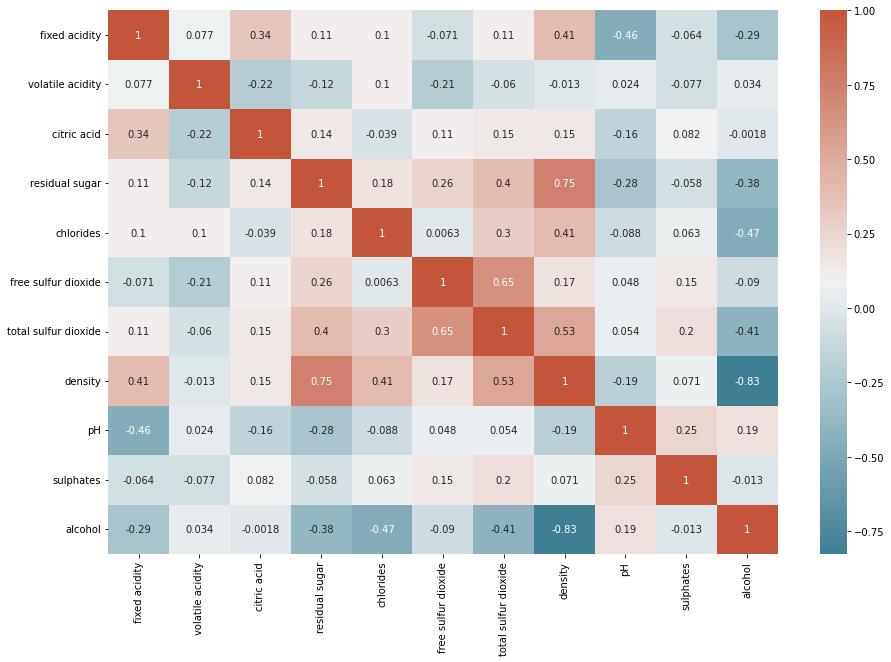

In [18]:
corr = balanced_scaled_df.corr()
plt.subplots(figsize=(15,10))
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot=True, cmap=sns.diverging_palette(220, 20, as_cmap=True))

In [19]:
columns = np.full((corr.shape[0],), True, dtype=bool)
for i in range(corr.shape[0]):
    for j in range(i + 1, corr.shape[0]):
        if abs(corr.iloc[i, j]) >= 0.8:
            if columns[j]:
                columns[j] = False
selected_columns = balanced_scaled_df.columns[columns]
print(selected_columns)

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates'],
      dtype='object')


In [20]:
reduced_df = balanced_scaled_df[selected_columns]

In [21]:
reduced_df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates
0,6.2,0.450,0.26,4.4,0.063,63.0,206.0,0.9940,3.27,0.52
1,9.8,0.360,0.46,10.5,0.038,4.0,83.0,0.9956,2.89,0.30
2,5.5,0.485,0.00,1.5,0.065,8.0,103.0,0.9940,3.63,0.40
3,6.4,0.595,0.14,5.2,0.058,15.0,97.0,0.9951,3.38,0.36
4,7.6,0.480,0.37,0.8,0.037,4.0,100.0,0.9902,3.03,0.39


In [22]:
X = reduced_df.iloc[:, :].values
print(X.shape)

(11407, 10)


#### Split data in train and test 

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

In [24]:
X_test[:5]

array([[5.23523755e+00, 2.42349170e-01, 4.43539782e-01, 3.70603319e+00,
        2.75872926e-02, 2.11761878e+01, 1.27823812e+02, 9.91874319e-01,
        3.53884144e+00, 4.80603319e-01],
       [7.10515160e+00, 3.92360612e-01, 3.47896968e-01, 2.91803060e+00,
        3.76309096e-02, 3.32103032e+01, 1.09184545e+02, 9.90708973e-01,
        3.12815455e+00, 4.69742420e-01],
       [8.75081371e+00, 4.16998976e-01, 3.01083419e-01, 2.41007166e+00,
        4.89165814e-02, 7.32502559e+00, 1.75000000e+02, 9.95121668e-01,
        3.14791965e+00, 4.60834186e-01],
       [6.87773734e+00, 3.19273253e-01, 3.09227229e-01, 9.25087232e+00,
        4.07727711e-02, 9.76816868e+00, 1.75000000e+02, 9.95284545e-01,
        3.43295301e+00, 5.42272289e-01],
       [6.09984556e+00, 2.93847342e-01, 2.52289872e-01, 4.01542026e+00,
        2.77694684e-02, 3.82305316e+01, 9.75389367e+01, 9.90407710e-01,
        3.26308405e+00, 5.07663796e-01]])

In [25]:
y_test[:5]

7996    2
7791    2
1543    0
1730    0
8265    2
Name: quality, dtype: int64

In [26]:
print ('Train set:', X_train.shape, y_train.shape)
print ('Test set:', X_test.shape, y_test.shape)

Train set: (9125, 10) (9125,)
Test set: (2282, 10) (2282,)


#### Util functions 

In [27]:
def print_cros_val_score(model):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=7)
    scores = cross_val_score(model, X, y, cv=5, n_jobs = -1)
    print(scores.mean())

In [28]:
all_metrics = {}
def print_metrics(y_pred, model_name=''):

    confusion_mat = metrics.confusion_matrix(y_test, y_pred)
    print("Confusion matrix is : ", confusion_mat)
    
    acc =  metrics.accuracy_score(y_test, y_pred)
    print("Accuracy:", acc)
    
    recall = metrics.recall_score(y_test, y_pred, average='weighted')
    print("Recall_score is :", recall)
    
    precision = metrics.precision_score(y_test, y_pred, average='weighted')
    print("Precision Score is : ", precision)
    
    f1 = 2 * (recall * precision) / (recall + precision)
    print("F1 score is: ", f1)
    
    jacc = metrics.jaccard_score(y_test, y_pred, average='weighted')
    print("Jaccard: ", jacc)
    
    all_metrics[model_name] = {}
    all_metrics[model_name]['Accuracy'] = acc
    all_metrics[model_name]['Recall_score'] = recall
    all_metrics[model_name]['Precision'] = precision
    all_metrics[model_name]['F1'] = f1
    all_metrics[model_name]['Jaccard'] = jacc
    
    

In [29]:
test_cases = X_test[:3]
expected = [0, 1, 0]

def test_prediction(model):
    y_prediction_test = model.predict(test_cases)
    print("Predicted: ", y_prediction_test)
    print("Expected: ", expected)

In [30]:
def get_best_params(model, param):
    grid_svc = GridSearchCV(model, param_grid=param, scoring='accuracy', cv=10)
    grid_svc.fit(X_train, y_train)
    best = grid_svc.best_params_
    return best

# K nearest neighbor (KNN)

In [34]:
from sklearn.neighbors import KNeighborsClassifier
param = {
    'n_neighbors': [1, 2, 5, 8, 12, 20, 50],
}
get_best_params(KNeighborsClassifier(), param)

{'n_neighbors': 1}

In [31]:
from sklearn.neighbors import KNeighborsClassifier
k = 1
neigh = KNeighborsClassifier(n_neighbors=k, p=2, metric='minkowski')
neigh.fit(X_train, y_train)


KNeighborsClassifier(n_neighbors=1)

In [36]:
print_cros_val_score(neigh)

0.9698173942798279


In [32]:
y_pred = neigh.predict(X_test)

In [33]:
print_metrics(y_pred, 'KNN')

Confusion matrix is :  [[876   2   3]
 [  6 543  14]
 [  1   2 835]]
Accuracy: 0.9877300613496932
Recall_score is : 0.9877300613496932
Precision Score is :  0.9878081489634044
F1 score is:  0.9877691036132541
Jaccard:  0.9757500296155215


In [34]:
test_prediction(neigh)

Predicted:  [2 2 0]
Expected:  [0, 1, 0]


# SVM

In [40]:
from sklearn.svm import SVC

param = {
    'C': [1, 1.2],
    'gamma' :[0.9, 1.2]
}
get_best_params(SVC(), param)

{'C': 1.2, 'gamma': 1.2}

In [35]:
from sklearn.svm import SVC

svc = SVC(C=1.2, gamma=1.2, kernel='rbf')
svc.fit(X_train, y_train)

SVC(C=1.2, gamma=1.2)

In [32]:
print_cros_val_score(svc)

0.9939551225900243


In [36]:
y_pred = svc.predict(X_test)

In [37]:
print_metrics(y_pred, 'SVC')

Confusion matrix is :  [[805  75   1]
 [  0 559   4]
 [  1  34 803]]
Accuracy: 0.9496056091148116
Recall_score is : 0.9496056091148116
Precision Score is :  0.9569914714545996
F1 score is:  0.9532842344402621
Jaccard:  0.9073853718488176


In [38]:
test_prediction(svc)

Predicted:  [2 2 0]
Expected:  [0, 1, 0]


In [47]:
from sklearn.svm import NuSVC

param = {
    'nu': [0.2, 0.5, 0.8],
    'gamma' :[0.1, 1, 1.5]
}
get_best_params(NuSVC(), param)

{'gamma': 1.5, 'nu': 0.2}

In [39]:
from sklearn.svm import NuSVC

nuSvc = NuSVC(gamma=1.5, nu=0.2)
nuSvc.fit(X_train, y_train)

NuSVC(gamma=1.5, nu=0.2)

In [49]:
print_cros_val_score(nuSvc)

0.9919300168225036


In [40]:
y_pred = nuSvc.predict(X_test)

In [41]:
print_metrics(y_pred, 'NuSVC')

Confusion matrix is :  [[791  89   1]
 [  0 559   4]
 [  1  41 796]]
Accuracy: 0.9404031551270815
Recall_score is : 0.9404031551270815
Precision Score is :  0.9506705740008369
F1 score is:  0.945508991539046
Jaccard:  0.8919890561135208


In [42]:
test_prediction(nuSvc)

Predicted:  [2 2 0]
Expected:  [0, 1, 0]


# Bagging

## Random Forest Classifier

In [53]:
from sklearn.ensemble import RandomForestClassifier

param = {
    'n_estimators': [50, 100, 200],
    'max_features' :['sqrt', 'log2', None]
}
get_best_params(RandomForestClassifier(), param)

{'max_features': 'sqrt', 'n_estimators': 200}

In [43]:
from sklearn.ensemble import RandomForestClassifier

n_estimators = 200
max_features = 'sqrt'
rf = RandomForestClassifier(n_estimators=n_estimators, max_features=max_features)
rf.fit(X_train, y_train)

RandomForestClassifier(max_features='sqrt', n_estimators=200)

In [55]:
print_cros_val_score(rf)

0.9659430418094723


In [44]:
y_pred = rf.predict(X_test)

In [45]:
print_metrics(y_pred, 'RandomForestClassifier')

Confusion matrix is :  [[874   5   2]
 [ 23 522  18]
 [  0   3 835]]
Accuracy: 0.9776511831726555
Recall_score is : 0.9776511831726555
Precision Score is :  0.9777869430418153
F1 score is:  0.9777190583945469
Jaccard:  0.9561726204025321


In [43]:
test_prediction(rf)

Predicted:  [1 0 0]
Expected:  [0, 1, 0]


## Extra Trees 

In [59]:
from sklearn.ensemble import ExtraTreesClassifier

param = {
    'n_estimators': [50, 100, 200],
    'max_features' :['sqrt', 'log2', None]
}
get_best_params(ExtraTreesClassifier(), param)

{'max_features': 'log2', 'n_estimators': 200}

In [46]:
from sklearn.ensemble import ExtraTreesClassifier


n_estimators = 200
max_features = 'log2'
et = ExtraTreesClassifier(n_estimators=n_estimators, max_features=max_features, random_state=seed)
et.fit(X_train, y_train)

ExtraTreesClassifier(max_features='log2', n_estimators=200, random_state=33)

In [61]:
print_cros_val_score(et)

0.9763538175883231


In [47]:
y_pred = et.predict(X_test)

In [48]:
print_metrics(y_pred, 'ExtraTreesClassifier')

Confusion matrix is :  [[876   5   0]
 [ 21 525  17]
 [  0   2 836]]
Accuracy: 0.9802804557405784
Recall_score is : 0.9802804557405784
Precision Score is :  0.9803968589409768
F1 score is:  0.9803386538854142
Jaccard:  0.9612338873201076


In [49]:
test_prediction(et)

Predicted:  [2 2 0]
Expected:  [0, 1, 0]


# Boosting

## AdaBoost 

In [67]:
from sklearn.ensemble import AdaBoostClassifier


param = {
    'n_estimators': [50, 100, 200, 500],
}
get_best_params(AdaBoostClassifier(), param)

{'n_estimators': 200}

In [50]:
from sklearn.ensemble import AdaBoostClassifier


n_estimators = 500
ab = AdaBoostClassifier(n_estimators=n_estimators, random_state=7)
ab.fit(X_train, y_train)

AdaBoostClassifier(n_estimators=500, random_state=7)

In [71]:
print_cros_val_score(ab)

0.7810511932191668


In [51]:
y_pred = ab.predict(X_test)

In [52]:
print_metrics(y_pred, 'AdaBoostClassifier')

Confusion matrix is :  [[780  97   4]
 [121 321 121]
 [  0 109 729]]
Accuracy: 0.8019281332164768
Recall_score is : 0.8019281332164768
Precision Score is :  0.7979648197473037
F1 score is:  0.7999415674491873
Jaccard:  0.6815042147809685


In [51]:
test_prediction(ab)

Predicted:  [0 0 1]
Expected:  [0, 1, 0]


# Gradient Boosting

In [76]:
from sklearn.ensemble import GradientBoostingClassifier


param = {
    'n_estimators': [100, 500],
    'learning_rate': [0.1, 0.4, 0.7],
    'max_features' :['sqrt', 'log2', None],
}
get_best_params(GradientBoostingClassifier(), param)

{'learning_rate': 0.7, 'max_features': 'log2', 'n_estimators': 500}

In [53]:
from sklearn.ensemble import GradientBoostingClassifier

n_estimators=500
learning_rate=0.7
max_features='log2'
gb = GradientBoostingClassifier(n_estimators=n_estimators, learning_rate=learning_rate, max_features=max_features, random_state=seed)
gb.fit(X_train, y_train)

GradientBoostingClassifier(learning_rate=0.7, max_features='log2',
                           n_estimators=500, random_state=33)

In [78]:
print_cros_val_score(gb)

0.9708670833386239


In [54]:
y_pred = gb.predict(X_test)

In [55]:
print_metrics(y_pred, 'GradientBoostingClassifier')

Confusion matrix is :  [[874   5   2]
 [ 11 546   6]
 [  0   5 833]]
Accuracy: 0.9872918492550394
Recall_score is : 0.9872918492550394
Precision Score is :  0.9872709709416998
F1 score is:  0.9872814099879899
Jaccard:  0.9749413272238092


In [56]:
test_prediction(gb)

Predicted:  [2 2 0]
Expected:  [0, 1, 0]


In [57]:
metrics_df = pd.DataFrame(all_metrics)
metrics_df['Best'] = metrics_df.idxmax(axis=1)
metrics_df

,KNN,SVC,NuSVC,RandomForestClassifier,ExtraTreesClassifier,AdaBoostClassifier,GradientBoostingClassifier,Best
Accuracy,0.987730,0.949606,0.940403,0.977651,0.980280,0.801928,0.987292,KNN
Recall_score,0.987730,0.949606,0.940403,0.977651,0.980280,0.801928,0.987292,KNN
Precision,0.987808,0.956991,0.950671,0.977787,0.980397,0.797965,0.987271,KNN
F1,0.987769,0.953284,0.945509,0.977719,0.980339,0.799942,0.987281,KNN
Jaccard,0.975750,0.907385,0.891989,0.956173,0.961234,0.681504,0.974941,KNN
